<h1><center>ParuVendu</center></h1>
<h2><center>Webscrapping - Analyse et preprocessing</center></h2>

### Objectifs : 
* Récupérer les annonces de ventes de biens immobiliers ancien IDF à partir du site https://www.paruvendu.fr/immobilier/  
une recherche sur les biens en île-de-France :   
https://www.paruvendu.fr/immobilier/annonceimmofo/liste/listeAnnonces?tt=1&at=1&nbp0=99&pa=FR&lo=75,77,78,91,92,93,94,95&lol=0&ray=50&p=1  


* Modéliser la BDD et la présenter sous format MCD/MLD    


* Nettoyer les données et les préparer selon le schéma MCD/MLD pour la partie DB/SQL


### Librables :
7 tables représentant la BDD modélisée et conçue. Elles seront l'entrée principale du script qui se chargera de la création de la BDD & l'insertion des données.    

Le récapitulatif de ces tables :  

**annonce_bien : Informations de l'annonce sur le bien présenté**  
    │   
    └─── `id_entite_bien` : identifiant de l'annonce/bien  
    └─── `url` : lien https pour avoir accès à l'annonce pour plus d'informations  
    └─── `id_type_bien` : identifiant du type de bien. Lien avec la table typebien    
    └─── `prix` : prix du bien    
    └─── `nb_pieces` : nombre de pièces dans le bien   
    └─── `surface` : surface du bien  
    └─── `date_annonce` : date de la création de l'annonce   
    └─── `id_classe_energie` : Classe de la consommation de l'énergie --> lien avec la table class_energetique   
    └─── `id_gaz_effet_serre` : Classe de l'indicateur du gaz à l'effet de serre --> lien avec la table gaz_effet_serre   
    └─── `id_emplacement` : identifiant du couple : code postal + nom de la ville/commune --> lien avec la table emplacement         
          
**dependance : Table référentielle des types de dépendances que nous avons à disposition**   
    │   
    └─── `id_dependance` : identifiant de la dépendance   
    └─── `libelle_dependance` : Libellé de la dépendance : parking, cave, piscine...  
         
**lien_bien_dependance : Table d'association entre la table dépendance et annonce_bien**  
    │   
    └─── `id_entite_bien` : identifiant du bien --> lien avec la table annonce_bien  
    └─── `id_dependance` : identifiant de la dépendance --> lien avec la table dependance  
   
**gaz_effet_serre : Table référentielle des indicateurs de gaz effet de serre. Elle fait le lien entre la classe & l'intervalle des valeurs**   
    │   
    └─── `id_gaz_effet_serre` : Classe de l'indice d’émissions de gaz à effet de serre  
    └─── `lb_gaz_effet_serre` : Libellé (=intervalle) de l'indice d’émissions de gaz à effet de serre  
   
**class_energetique : Table référentielle des indicateurs de la consommation énérgétique. Elle fait le lien entre la classe & l'intervalle des valeurs**   
    │   
    └─── `id_classe_energetique` : Classe Énergie  
    └─── `lb_classe_energetique` : Libellé (=intervalle) de la consommation de l'énnergie  
   
**emplacement : Table référentielle des codes postaux et les communes associées**   
    │   
    └─── `id_emplacement` : identifiant du couple code postal + ville  
    └─── `cd_postal` : code postal  
    └─── `lb_ville` : ville  
   
**typebien : Table référentielles des types de biens (appartement, maison, ..)**   
    │   
    └─── `id_type_bien` : identifiant du type du bien  
    └─── `lb_type_bien` : libellé du type du bien : maison, appt..


### Librairies nécessaires pour ce notebook

In [1]:
## librairies pour le webscrapping
import requests
from bs4 import BeautifulSoup

## librairies pour la gestion des dataframes + les expressions logiques
import pandas as pd
import re

## Librairies qui vont nous aider à savoir le temps écouler entre le lancement & la fin d'une opération
## ainsi de laisser un temps d'attente entre la lecture de chaque lien afin de pas avoir des messages de robot du site
from datetime import datetime
import time

<h1><center><font color='gray'>Webscrapping des données</font></center></h1>

Avant de commencer cette partie, nous avons investigué et inspecté les pages et leurs codes HTML associés.  
Cela nous a permis de repérer les informations que nous avons trouvé intéressantes à notre sujet ainsi les balises contenant ces données.

### Définition des fonctions de lecture des liens

* La première fonction lit un url que nous donnons en entrée

* La deuxième fonction va lire le lien selon un indice qui fait référence à la page & utilisera la première fonction pour la lecture

In [2]:
## cette fonction sera utilisée pour lire la page de chacune des annonces
def lecteur_url(url):
    return BeautifulSoup(requests.get(url).content,'html')

## cette fonction sera utilisée pour récupérer les identifiants & les liens de chacune des annonces 
def lecteur_url_index(index):
    url='https://www.paruvendu.fr/immobilier/annonceimmofo/liste/listeAnnonces?tt=1&at=1&nbp0=99&pa=FR&lo=75,77,78,91,92,93,94,95&lol=0&ray=50&p='+str(index)    
    return lecteur_url(url)

## fonction qui va initialiser un élément au NC à chaque fois 
def init_ce():
    return "NC"

### Webscrapping 1 - Collecter les informations de chaque page

Dans cette partie on va chercher les informations basiques affichées dans chaque annonce de la page. On va en profiter pour enregistrer le lien vers l'annonce & l'identifiant renseigné afin de pouvoir ouvrir les liens pour plus d'informations & tracer l'unicité de chaque annonce.

In [22]:
listids=[]
urls=[]
typebien=[]
emplacements=[]
prices=[]

## init boucle
index=1
soup=lecteur_url_index(index)
boucle=True

## Tant qu'on est pas arrivés au bout
while boucle:
    
    print("at page : ",index)
    
    ## si on ne voit plus de next page
    if isinstance(soup.find("div", attrs={"class": "pv15-pagsuiv flol"}),type(None)):
        print("didn't find the next page button")
        boucle=False

    ## on récupèe id annonce & son link
    for annonce in soup.find_all("div", attrs={"class": "ergov3-annonce"}):
        
        annonce_id=annonce.get("data-id")
        annonce_url=annonce.find_all("a")[1].get("href")
        
        ## on a un if car il y a des divs avec la même classe & sans infos dedans
        if ((not isinstance(annonce_url,type(None))) & (not isinstance(annonce_id,type(None)))):
            annonce_url=str("https://www.paruvendu.fr")+annonce_url
            listids.append(annonce_id)
            urls.append(annonce_url)
            
            ## on récupère les informations relatives au type, piece & m2
            c=annonce.find_all("div",attrs={"class":"ergov3-h3"})
            if len(c)>0:
                typebien.append([line for line in c[0].find("span").text.strip().splitlines()][0])
                emplacements.append(c[0].find("cite").text.strip())
        
            ## on réucpère le prix sans le symbole euros
            for e in annonce.find_all("div",attrs={"class":"ergov3-priceannonce"}):
                prices.append(re.sub('\D', '', e.text))


    ## incrémenter l'index = page
    index+=1
    
    ## on lit l'url de la page index 
    time.sleep(2)
    soup=lecteur_url_index(index)

## on drop les duplicates pour enlever la possibilité de tomber sur une annonce à plusieurs reprises
## car le site peut afficher des annonces identiques plusieurs fois 
df_annonces=pd.DataFrame({"id":listids,"url":urls,"lb_type_bien":typebien,"ville":emplacements,"price":prices},
                         columns=["id","url",'lb_type_bien','ville',"price"]).drop_duplicates()

df_annonces.shape

at page :  1
at page :  2
at page :  3
at page :  4
at page :  5
at page :  6
at page :  7
at page :  8
at page :  9
at page :  10
at page :  11
at page :  12
at page :  13
at page :  14
at page :  15
at page :  16
at page :  17
at page :  18
at page :  19
at page :  20
at page :  21
at page :  22
at page :  23
at page :  24
at page :  25
at page :  26
at page :  27
at page :  28
at page :  29
at page :  30
at page :  31
at page :  32
at page :  33
at page :  34
at page :  35
at page :  36
at page :  37
at page :  38
at page :  39
at page :  40
at page :  41
at page :  42
at page :  43
at page :  44
at page :  45
at page :  46
at page :  47
at page :  48
at page :  49
at page :  50
at page :  51
at page :  52
at page :  53
at page :  54
at page :  55
at page :  56
at page :  57
at page :  58
at page :  59
at page :  60
at page :  61
at page :  62
at page :  63
at page :  64
at page :  65
at page :  66
at page :  67
at page :  68
at page :  69
at page :  70
at page :  71
at page :  72
a

(11998, 5)

In [23]:
## copie de la table
df_annonce=df_annonces.copy()

<h4><center> Analyse des résultats du 1<sup>er</sup> webscrapping</center></h4>

<center>Nous allons analysé les informations récupérées et procéder à un petit nettoyage très basique afin d'alléger la base.  
Pourquoi ? Parce ce que l'étape d'après est très lourde et donc si on peut enlever dès lors des cas particuliers on pourra alléger le traitement qui suit.   </center>



##### Zoom macro sur la table

In [24]:
df_annonces.columns

Index(['id', 'url', 'lb_type_bien', 'ville', 'price'], dtype='object')

In [25]:
df_annonces.isna().sum()

id              0
url             0
lb_type_bien    0
ville           0
price           0
dtype: int64

In [26]:
df_annonces.isnull().sum()

id              0
url             0
lb_type_bien    0
ville           0
price           0
dtype: int64

##    ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ************** ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* 

##### Zoom sur les colonnes

**La colonne price**

On remarque qu'il y a des observations pour lesquelles le prix est vide & n'est pas en digit

In [27]:
df_annonces[~df_annonces["price"].str.isdigit()]

,id,url,lb_type_bien,ville,price
422,1263759745,https://www.paruvendu.fr/immobilier/vente/appa...,Appartement,Cergy (95000),
4681,1263653698,https://www.paruvendu.fr/immobilier/vente/vill...,Villa,Verrières-le-Buisson (91370),


Par conséquent, on les enlève car le prix est une donnée importante dans notre dataset & c'est un des axes d'analyse que nous pensons regarder de plus près.

In [28]:
df_annonces=df_annonces[df_annonces["price"].str.isdigit()]
df_annonces.shape

(11996, 5)

In [29]:
## confirmation que nous n'avons plus de valeurs 
df_annonces[~df_annonces["price"].str.isdigit()]

,id,url,lb_type_bien,ville,price


In [30]:
## on parse la colonne price en int
df_annonces["price"]=df_annonces["price"].apply(lambda x:int(x))

**La colonne typebien**

Quelques valeurs à normaliser --> action plus bas dans le notebook

In [31]:
df_annonces.lb_type_bien.value_counts()

Appartement                                              6892
Maison                                                   4881
Villa                                                      75
Duplex/triplex                                             62
Propriété/château                                          44
Loft                                                       27
Chalet                                                      6
Ferme                                                       3
Moulin                                                      2
Enchère : \t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tVilla       1
Plateau                                                     1
Hôtel Particulier                                           1
Atelier                                                     1
Name: lb_type_bien, dtype: int64

**Les colonnes id & url**

In [32]:
### on vérifie qu'on a bien une cohérence de longueur de tous les ids
### ça permet de valider que nous n'avons pas des valeurs pour l'id moins en longueur
### si il y en avait, on aurait regardé ces cas de plus près
[i for i,val in enumerate(df_annonces["id"].str.len()) if val<len("1262896486")]

[]

In [33]:
### On a essayé plusieurs seuils pour voir si l'url est trop petit en longueur
### pourquoi ? parce qu'on a remarqué que les urls sur lesquels on a fait des tests étaient d'une certaine longueur
[i for i,val in enumerate(df_annonces["url"].str.len()) if val<70]

[]

**La colonne ville**

In [34]:
df_annonces.ville.value_counts()
## On remarque la forme de la ville est : nom_ville (code postal) sauf pour quelques cas

Paris 20                          125
Meaux (77100)                     121
La Ferté-sous-Jouarre (77260)     121
Paris 18                          120
Montreuil (93100)                 115
                                 ... 
Boullay-les-Troux (91470)           1
Saint-Cloud (92)                    1
Saint-Martin-du-Tertre (95270)      1
Tacoignières (78910)                1
Pierrelaye (95220)                  1
Name: ville, Length: 975, dtype: int64

In [35]:
## on retourne toutes les observations dont la ville ne contient pas le code postal entre ()
df_annonces[df_annonces.ville.str.contains("[a-zA-Z0-9_-]+$",regex=True)].ville.value_counts()

Paris 20                          125
Paris 18                          120
Paris 19                          108
Paris 15                          101
Paris 13                           94
Paris 17                           83
Paris 11                           69
Paris 10                           57
Paris 12                           55
Paris 14                           45
Paris 16                           42
Paris 8                            28
Paris 9                            27
Paris 7                            26
Paris 1                            25
Paris 4                            21
Paris 3                            19
Paris 5                            19
Paris 6                            16
Paris 2                            11
Immobilier  / Vente immobilier      2
Name: ville, dtype: int64

In [36]:
df_annonces[df_annonces["ville"].str.contains("Immobilier")].url.values.tolist()

['https://www.paruvendu.fr/immobilier/prestige/villa-8-pieces-entierement-renovee/particulier/1261613249A1KIVHVI000',
 'https://www.paruvendu.fr/immobilier/vente/particulier-appartement-6pieces-a-chevilly-larue-94/particulier/1259670853A1KIVHAP000']

* On va sur les sites des cas particuliers et on remarque que les balises ont été changées pour ces deux cas là donc on les enlève.  

* De plus pour les autres cas on remarque c'est plutôt les arrondissements. On va gèrer ces cas plus tard dans le notebook.

In [37]:
df_annonces=df_annonces[~df_annonces["ville"].str.contains("Immobilier")]

In [38]:
df_annonces.shape

(11994, 5)

In [39]:
''' 
                Partie backup en cas de coupure
                
df_annonces=pd.read_csv("df_annonces.csv")
df_annonces.shape

df_annonces.to_csv('tmp_data/df_annonces.csv', index=False, encoding='utf-8')
'''

##    ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ************** ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ************** ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ************** ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ************** ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* *******

###  Webscrapping 2 - Collecte d'informations par annonce


Dans cette partie, nous allons enrichir chaque annonce de bien avec plus d'informations en allant directement sur la page de chacune des annonces récupérées, via l'url récupéré dans la partie au-dessus, et scrapper une deuxième fois plus de données.

In [40]:
print("start Time =", datetime.now().strftime("%H:%M:%S"))

urls=df_annonces.url.values.tolist()

pieces=[]
surfaces=[]

## date annonce
dates=[]

## Energie
classe_energie=[]
gaz_effet_serre=[]

### dependance & annexes que nous allons fusionnés dans une seule table
dependance=[]
annexes=[]



id_dep=1
dict_dep={}

counter=1

for url in urls:
    print("**************************")
    print(counter)
    time.sleep(1)
    soup=lecteur_url(url)
    
    ## nb piece
    ce=init_ce()
    for e in soup.find_all("li",attrs={"class":"nbp"}):
        ce = e.find("span").text.split("/")[-1]  ## des fois on a 2/3 pièces ou 3/4
    pieces.append(ce)
    
    ## surface du bien
    ce=init_ce()
    for e in soup.find_all("li",attrs={"class":"surf"}):
        ce=re.sub('\D', '', e.text.replace("m2",""))
    surfaces.append(ce)
    
    ## date de l'annonce
    ce=init_ce()
    for e in soup.find_all("div",attrs={"class":"vvdetails14_refdate"}):
        annonce_date=[p for p in e.find_all("p") if not (p.find("span"))]
        if len(annonce_date)>0:
            mystring=annonce_date[0].text.replace(" ","")
            ce=mystring[mystring.find("Le")+2 : mystring.find("à")]
    dates.append(ce)
    
    
    ## dependances & annexes
    tmpdep=[]
    tmpann=[]
    for e in soup.find_all("ul",attrs={"class":"crit-alignbloc"}):      

        element=[a for a in e.text.splitlines() if "Dépendance" in a]
        ann=[a for a in e.text.splitlines() if "Annexes" in a]

        if len(element)>0:
            tmpdep.append(element[0].split("-")[-1].strip())
        if len(ann)>0:
            tmpann.append(ann[0].split("-")[-1].strip())

    tmpdep="NC" if len(tmpdep)<1 else ",".join(tmpdep)
    dependance.append(tmpdep)
    tmpann="NC" if len(tmpann)<1 else ",".join(tmpann)
    annexes.append(tmpann)
    
    ## classe_energie
    ce=init_ce()
    for e in soup.find_all("div",attrs={"class":"DPE_consEnerNote"}):
        ce = ce if isinstance(e,type(None)) else e.text
    classe_energie.append(ce)

    ## gaz_effet_serre
    ce=init_ce()
    for e in soup.find_all("div",attrs={"class":"DPE_effSerreNote"}):
        ce = ce if isinstance(e,type(None)) else e.text
    gaz_effet_serre.append(ce)

    counter+=1

print("End Time =", datetime.now().strftime("%H:%M:%S"))

## on crée un df avec les données comme dans le dernier bloc de code 
## & on fait un inner join afin d'enrichir
df=pd.DataFrame({"url":urls,"pieces":pieces,'surface':surfaces,'date_annonce':dates,
                 'dependance':dependance,"annexe":annexes,"classe_energie":classe_energie,
                 "gaz_effet_serre":gaz_effet_serre},
                         columns=["url","pieces",'surface','date_annonce','dependance',
                                  "annexe","classe_energie","gaz_effet_serre"]) 


df_final=df_annonces.merge(df,on='url',how='inner').drop_duplicates()

start Time = 17:05:43
**************************
1
**************************
2
**************************
3
**************************
4
**************************
5
**************************
6
**************************
7
**************************
8
**************************
9
**************************
10
**************************
11
**************************
12
**************************
13
**************************
14
**************************
15
**************************
16
**************************
17
**************************
18
**************************
19
**************************
20
**************************
21
**************************
22
**************************
23
**************************
24
**************************
25
**************************
26
**************************
27
**************************
28
**************************
29
**************************
30
**************************
31
**************************
32
**************************


**************************
269
**************************
270
**************************
271
**************************
272
**************************
273
**************************
274
**************************
275
**************************
276
**************************
277
**************************
278
**************************
279
**************************
280
**************************
281
**************************
282
**************************
283
**************************
284
**************************
285
**************************
286
**************************
287
**************************
288
**************************
289
**************************
290
**************************
291
**************************
292
**************************
293
**************************
294
**************************
295
**************************
296
**************************
297
**************************
298
**************************
299
**************************
300
********

**************************
534
**************************
535
**************************
536
**************************
537
**************************
538
**************************
539
**************************
540
**************************
541
**************************
542
**************************
543
**************************
544
**************************
545
**************************
546
**************************
547
**************************
548
**************************
549
**************************
550
**************************
551
**************************
552
**************************
553
**************************
554
**************************
555
**************************
556
**************************
557
**************************
558
**************************
559
**************************
560
**************************
561
**************************
562
**************************
563
**************************
564
**************************
565
********

**************************
799
**************************
800
**************************
801
**************************
802
**************************
803
**************************
804
**************************
805
**************************
806
**************************
807
**************************
808
**************************
809
**************************
810
**************************
811
**************************
812
**************************
813
**************************
814
**************************
815
**************************
816
**************************
817
**************************
818
**************************
819
**************************
820
**************************
821
**************************
822
**************************
823
**************************
824
**************************
825
**************************
826
**************************
827
**************************
828
**************************
829
**************************
830
********

**************************
1062
**************************
1063
**************************
1064
**************************
1065
**************************
1066
**************************
1067
**************************
1068
**************************
1069
**************************
1070
**************************
1071
**************************
1072
**************************
1073
**************************
1074
**************************
1075
**************************
1076
**************************
1077
**************************
1078
**************************
1079
**************************
1080
**************************
1081
**************************
1082
**************************
1083
**************************
1084
**************************
1085
**************************
1086
**************************
1087
**************************
1088
**************************
1089
**************************
1090
**************************
1091
**************************
1092
********

**************************
1319
**************************
1320
**************************
1321
**************************
1322
**************************
1323
**************************
1324
**************************
1325
**************************
1326
**************************
1327
**************************
1328
**************************
1329
**************************
1330
**************************
1331
**************************
1332
**************************
1333
**************************
1334
**************************
1335
**************************
1336
**************************
1337
**************************
1338
**************************
1339
**************************
1340
**************************
1341
**************************
1342
**************************
1343
**************************
1344
**************************
1345
**************************
1346
**************************
1347
**************************
1348
**************************
1349
********

**************************
1576
**************************
1577
**************************
1578
**************************
1579
**************************
1580
**************************
1581
**************************
1582
**************************
1583
**************************
1584
**************************
1585
**************************
1586
**************************
1587
**************************
1588
**************************
1589
**************************
1590
**************************
1591
**************************
1592
**************************
1593
**************************
1594
**************************
1595
**************************
1596
**************************
1597
**************************
1598
**************************
1599
**************************
1600
**************************
1601
**************************
1602
**************************
1603
**************************
1604
**************************
1605
**************************
1606
********

**************************
1833
**************************
1834
**************************
1835
**************************
1836
**************************
1837
**************************
1838
**************************
1839
**************************
1840
**************************
1841
**************************
1842
**************************
1843
**************************
1844
**************************
1845
**************************
1846
**************************
1847
**************************
1848
**************************
1849
**************************
1850
**************************
1851
**************************
1852
**************************
1853
**************************
1854
**************************
1855
**************************
1856
**************************
1857
**************************
1858
**************************
1859
**************************
1860
**************************
1861
**************************
1862
**************************
1863
********

**************************
2090
**************************
2091
**************************
2092
**************************
2093
**************************
2094
**************************
2095
**************************
2096
**************************
2097
**************************
2098
**************************
2099
**************************
2100
**************************
2101
**************************
2102
**************************
2103
**************************
2104
**************************
2105
**************************
2106
**************************
2107
**************************
2108
**************************
2109
**************************
2110
**************************
2111
**************************
2112
**************************
2113
**************************
2114
**************************
2115
**************************
2116
**************************
2117
**************************
2118
**************************
2119
**************************
2120
********

**************************
2347
**************************
2348
**************************
2349
**************************
2350
**************************
2351
**************************
2352
**************************
2353
**************************
2354
**************************
2355
**************************
2356
**************************
2357
**************************
2358
**************************
2359
**************************
2360
**************************
2361
**************************
2362
**************************
2363
**************************
2364
**************************
2365
**************************
2366
**************************
2367
**************************
2368
**************************
2369
**************************
2370
**************************
2371
**************************
2372
**************************
2373
**************************
2374
**************************
2375
**************************
2376
**************************
2377
********

**************************
2604
**************************
2605
**************************
2606
**************************
2607
**************************
2608
**************************
2609
**************************
2610
**************************
2611
**************************
2612
**************************
2613
**************************
2614
**************************
2615
**************************
2616
**************************
2617
**************************
2618
**************************
2619
**************************
2620
**************************
2621
**************************
2622
**************************
2623
**************************
2624
**************************
2625
**************************
2626
**************************
2627
**************************
2628
**************************
2629
**************************
2630
**************************
2631
**************************
2632
**************************
2633
**************************
2634
********

**************************
2861
**************************
2862
**************************
2863
**************************
2864
**************************
2865
**************************
2866
**************************
2867
**************************
2868
**************************
2869
**************************
2870
**************************
2871
**************************
2872
**************************
2873
**************************
2874
**************************
2875
**************************
2876
**************************
2877
**************************
2878
**************************
2879
**************************
2880
**************************
2881
**************************
2882
**************************
2883
**************************
2884
**************************
2885
**************************
2886
**************************
2887
**************************
2888
**************************
2889
**************************
2890
**************************
2891
********

**************************
3118
**************************
3119
**************************
3120
**************************
3121
**************************
3122
**************************
3123
**************************
3124
**************************
3125
**************************
3126
**************************
3127
**************************
3128
**************************
3129
**************************
3130
**************************
3131
**************************
3132
**************************
3133
**************************
3134
**************************
3135
**************************
3136
**************************
3137
**************************
3138
**************************
3139
**************************
3140
**************************
3141
**************************
3142
**************************
3143
**************************
3144
**************************
3145
**************************
3146
**************************
3147
**************************
3148
********

**************************
3375
**************************
3376
**************************
3377
**************************
3378
**************************
3379
**************************
3380
**************************
3381
**************************
3382
**************************
3383
**************************
3384
**************************
3385
**************************
3386
**************************
3387
**************************
3388
**************************
3389
**************************
3390
**************************
3391
**************************
3392
**************************
3393
**************************
3394
**************************
3395
**************************
3396
**************************
3397
**************************
3398
**************************
3399
**************************
3400
**************************
3401
**************************
3402
**************************
3403
**************************
3404
**************************
3405
********

**************************
3632
**************************
3633
**************************
3634
**************************
3635
**************************
3636
**************************
3637
**************************
3638
**************************
3639
**************************
3640
**************************
3641
**************************
3642
**************************
3643
**************************
3644
**************************
3645
**************************
3646
**************************
3647
**************************
3648
**************************
3649
**************************
3650
**************************
3651
**************************
3652
**************************
3653
**************************
3654
**************************
3655
**************************
3656
**************************
3657
**************************
3658
**************************
3659
**************************
3660
**************************
3661
**************************
3662
********

**************************
3889
**************************
3890
**************************
3891
**************************
3892
**************************
3893
**************************
3894
**************************
3895
**************************
3896
**************************
3897
**************************
3898
**************************
3899
**************************
3900
**************************
3901
**************************
3902
**************************
3903
**************************
3904
**************************
3905
**************************
3906
**************************
3907
**************************
3908
**************************
3909
**************************
3910
**************************
3911
**************************
3912
**************************
3913
**************************
3914
**************************
3915
**************************
3916
**************************
3917
**************************
3918
**************************
3919
********

**************************
4146
**************************
4147
**************************
4148
**************************
4149
**************************
4150
**************************
4151
**************************
4152
**************************
4153
**************************
4154
**************************
4155
**************************
4156
**************************
4157
**************************
4158
**************************
4159
**************************
4160
**************************
4161
**************************
4162
**************************
4163
**************************
4164
**************************
4165
**************************
4166
**************************
4167
**************************
4168
**************************
4169
**************************
4170
**************************
4171
**************************
4172
**************************
4173
**************************
4174
**************************
4175
**************************
4176
********

**************************
4403
**************************
4404
**************************
4405
**************************
4406
**************************
4407
**************************
4408
**************************
4409
**************************
4410
**************************
4411
**************************
4412
**************************
4413
**************************
4414
**************************
4415
**************************
4416
**************************
4417
**************************
4418
**************************
4419
**************************
4420
**************************
4421
**************************
4422
**************************
4423
**************************
4424
**************************
4425
**************************
4426
**************************
4427
**************************
4428
**************************
4429
**************************
4430
**************************
4431
**************************
4432
**************************
4433
********

**************************
4660
**************************
4661
**************************
4662
**************************
4663
**************************
4664
**************************
4665
**************************
4666
**************************
4667
**************************
4668
**************************
4669
**************************
4670
**************************
4671
**************************
4672
**************************
4673
**************************
4674
**************************
4675
**************************
4676
**************************
4677
**************************
4678
**************************
4679
**************************
4680
**************************
4681
**************************
4682
**************************
4683
**************************
4684
**************************
4685
**************************
4686
**************************
4687
**************************
4688
**************************
4689
**************************
4690
********

**************************
4917
**************************
4918
**************************
4919
**************************
4920
**************************
4921
**************************
4922
**************************
4923
**************************
4924
**************************
4925
**************************
4926
**************************
4927
**************************
4928
**************************
4929
**************************
4930
**************************
4931
**************************
4932
**************************
4933
**************************
4934
**************************
4935
**************************
4936
**************************
4937
**************************
4938
**************************
4939
**************************
4940
**************************
4941
**************************
4942
**************************
4943
**************************
4944
**************************
4945
**************************
4946
**************************
4947
********

**************************
5174
**************************
5175
**************************
5176
**************************
5177
**************************
5178
**************************
5179
**************************
5180
**************************
5181
**************************
5182
**************************
5183
**************************
5184
**************************
5185
**************************
5186
**************************
5187
**************************
5188
**************************
5189
**************************
5190
**************************
5191
**************************
5192
**************************
5193
**************************
5194
**************************
5195
**************************
5196
**************************
5197
**************************
5198
**************************
5199
**************************
5200
**************************
5201
**************************
5202
**************************
5203
**************************
5204
********

**************************
5431
**************************
5432
**************************
5433
**************************
5434
**************************
5435
**************************
5436
**************************
5437
**************************
5438
**************************
5439
**************************
5440
**************************
5441
**************************
5442
**************************
5443
**************************
5444
**************************
5445
**************************
5446
**************************
5447
**************************
5448
**************************
5449
**************************
5450
**************************
5451
**************************
5452
**************************
5453
**************************
5454
**************************
5455
**************************
5456
**************************
5457
**************************
5458
**************************
5459
**************************
5460
**************************
5461
********

**************************
5688
**************************
5689
**************************
5690
**************************
5691
**************************
5692
**************************
5693
**************************
5694
**************************
5695
**************************
5696
**************************
5697
**************************
5698
**************************
5699
**************************
5700
**************************
5701
**************************
5702
**************************
5703
**************************
5704
**************************
5705
**************************
5706
**************************
5707
**************************
5708
**************************
5709
**************************
5710
**************************
5711
**************************
5712
**************************
5713
**************************
5714
**************************
5715
**************************
5716
**************************
5717
**************************
5718
********

**************************
5945
**************************
5946
**************************
5947
**************************
5948
**************************
5949
**************************
5950
**************************
5951
**************************
5952
**************************
5953
**************************
5954
**************************
5955
**************************
5956
**************************
5957
**************************
5958
**************************
5959
**************************
5960
**************************
5961
**************************
5962
**************************
5963
**************************
5964
**************************
5965
**************************
5966
**************************
5967
**************************
5968
**************************
5969
**************************
5970
**************************
5971
**************************
5972
**************************
5973
**************************
5974
**************************
5975
********

**************************
6202
**************************
6203
**************************
6204
**************************
6205
**************************
6206
**************************
6207
**************************
6208
**************************
6209
**************************
6210
**************************
6211
**************************
6212
**************************
6213
**************************
6214
**************************
6215
**************************
6216
**************************
6217
**************************
6218
**************************
6219
**************************
6220
**************************
6221
**************************
6222
**************************
6223
**************************
6224
**************************
6225
**************************
6226
**************************
6227
**************************
6228
**************************
6229
**************************
6230
**************************
6231
**************************
6232
********

**************************
6459
**************************
6460
**************************
6461
**************************
6462
**************************
6463
**************************
6464
**************************
6465
**************************
6466
**************************
6467
**************************
6468
**************************
6469
**************************
6470
**************************
6471
**************************
6472
**************************
6473
**************************
6474
**************************
6475
**************************
6476
**************************
6477
**************************
6478
**************************
6479
**************************
6480
**************************
6481
**************************
6482
**************************
6483
**************************
6484
**************************
6485
**************************
6486
**************************
6487
**************************
6488
**************************
6489
********

**************************
6716
**************************
6717
**************************
6718
**************************
6719
**************************
6720
**************************
6721
**************************
6722
**************************
6723
**************************
6724
**************************
6725
**************************
6726
**************************
6727
**************************
6728
**************************
6729
**************************
6730
**************************
6731
**************************
6732
**************************
6733
**************************
6734
**************************
6735
**************************
6736
**************************
6737
**************************
6738
**************************
6739
**************************
6740
**************************
6741
**************************
6742
**************************
6743
**************************
6744
**************************
6745
**************************
6746
********

**************************
6973
**************************
6974
**************************
6975
**************************
6976
**************************
6977
**************************
6978
**************************
6979
**************************
6980
**************************
6981
**************************
6982
**************************
6983
**************************
6984
**************************
6985
**************************
6986
**************************
6987
**************************
6988
**************************
6989
**************************
6990
**************************
6991
**************************
6992
**************************
6993
**************************
6994
**************************
6995
**************************
6996
**************************
6997
**************************
6998
**************************
6999
**************************
7000
**************************
7001
**************************
7002
**************************
7003
********

**************************
7230
**************************
7231
**************************
7232
**************************
7233
**************************
7234
**************************
7235
**************************
7236
**************************
7237
**************************
7238
**************************
7239
**************************
7240
**************************
7241
**************************
7242
**************************
7243
**************************
7244
**************************
7245
**************************
7246
**************************
7247
**************************
7248
**************************
7249
**************************
7250
**************************
7251
**************************
7252
**************************
7253
**************************
7254
**************************
7255
**************************
7256
**************************
7257
**************************
7258
**************************
7259
**************************
7260
********

**************************
7487
**************************
7488
**************************
7489
**************************
7490
**************************
7491
**************************
7492
**************************
7493
**************************
7494
**************************
7495
**************************
7496
**************************
7497
**************************
7498
**************************
7499
**************************
7500
**************************
7501
**************************
7502
**************************
7503
**************************
7504
**************************
7505
**************************
7506
**************************
7507
**************************
7508
**************************
7509
**************************
7510
**************************
7511
**************************
7512
**************************
7513
**************************
7514
**************************
7515
**************************
7516
**************************
7517
********

**************************
7744
**************************
7745
**************************
7746
**************************
7747
**************************
7748
**************************
7749
**************************
7750
**************************
7751
**************************
7752
**************************
7753
**************************
7754
**************************
7755
**************************
7756
**************************
7757
**************************
7758
**************************
7759
**************************
7760
**************************
7761
**************************
7762
**************************
7763
**************************
7764
**************************
7765
**************************
7766
**************************
7767
**************************
7768
**************************
7769
**************************
7770
**************************
7771
**************************
7772
**************************
7773
**************************
7774
********

**************************
8001
**************************
8002
**************************
8003
**************************
8004
**************************
8005
**************************
8006
**************************
8007
**************************
8008
**************************
8009
**************************
8010
**************************
8011
**************************
8012
**************************
8013
**************************
8014
**************************
8015
**************************
8016
**************************
8017
**************************
8018
**************************
8019
**************************
8020
**************************
8021
**************************
8022
**************************
8023
**************************
8024
**************************
8025
**************************
8026
**************************
8027
**************************
8028
**************************
8029
**************************
8030
**************************
8031
********

**************************
8258
**************************
8259
**************************
8260
**************************
8261
**************************
8262
**************************
8263
**************************
8264
**************************
8265
**************************
8266
**************************
8267
**************************
8268
**************************
8269
**************************
8270
**************************
8271
**************************
8272
**************************
8273
**************************
8274
**************************
8275
**************************
8276
**************************
8277
**************************
8278
**************************
8279
**************************
8280
**************************
8281
**************************
8282
**************************
8283
**************************
8284
**************************
8285
**************************
8286
**************************
8287
**************************
8288
********

**************************
8515
**************************
8516
**************************
8517
**************************
8518
**************************
8519
**************************
8520
**************************
8521
**************************
8522
**************************
8523
**************************
8524
**************************
8525
**************************
8526
**************************
8527
**************************
8528
**************************
8529
**************************
8530
**************************
8531
**************************
8532
**************************
8533
**************************
8534
**************************
8535
**************************
8536
**************************
8537
**************************
8538
**************************
8539
**************************
8540
**************************
8541
**************************
8542
**************************
8543
**************************
8544
**************************
8545
********

**************************
8772
**************************
8773
**************************
8774
**************************
8775
**************************
8776
**************************
8777
**************************
8778
**************************
8779
**************************
8780
**************************
8781
**************************
8782
**************************
8783
**************************
8784
**************************
8785
**************************
8786
**************************
8787
**************************
8788
**************************
8789
**************************
8790
**************************
8791
**************************
8792
**************************
8793
**************************
8794
**************************
8795
**************************
8796
**************************
8797
**************************
8798
**************************
8799
**************************
8800
**************************
8801
**************************
8802
********

**************************
9029
**************************
9030
**************************
9031
**************************
9032
**************************
9033
**************************
9034
**************************
9035
**************************
9036
**************************
9037
**************************
9038
**************************
9039
**************************
9040
**************************
9041
**************************
9042
**************************
9043
**************************
9044
**************************
9045
**************************
9046
**************************
9047
**************************
9048
**************************
9049
**************************
9050
**************************
9051
**************************
9052
**************************
9053
**************************
9054
**************************
9055
**************************
9056
**************************
9057
**************************
9058
**************************
9059
********

**************************
9286
**************************
9287
**************************
9288
**************************
9289
**************************
9290
**************************
9291
**************************
9292
**************************
9293
**************************
9294
**************************
9295
**************************
9296
**************************
9297
**************************
9298
**************************
9299
**************************
9300
**************************
9301
**************************
9302
**************************
9303
**************************
9304
**************************
9305
**************************
9306
**************************
9307
**************************
9308
**************************
9309
**************************
9310
**************************
9311
**************************
9312
**************************
9313
**************************
9314
**************************
9315
**************************
9316
********

**************************
9543
**************************
9544
**************************
9545
**************************
9546
**************************
9547
**************************
9548
**************************
9549
**************************
9550
**************************
9551
**************************
9552
**************************
9553
**************************
9554
**************************
9555
**************************
9556
**************************
9557
**************************
9558
**************************
9559
**************************
9560
**************************
9561
**************************
9562
**************************
9563
**************************
9564
**************************
9565
**************************
9566
**************************
9567
**************************
9568
**************************
9569
**************************
9570
**************************
9571
**************************
9572
**************************
9573
********

**************************
9800
**************************
9801
**************************
9802
**************************
9803
**************************
9804
**************************
9805
**************************
9806
**************************
9807
**************************
9808
**************************
9809
**************************
9810
**************************
9811
**************************
9812
**************************
9813
**************************
9814
**************************
9815
**************************
9816
**************************
9817
**************************
9818
**************************
9819
**************************
9820
**************************
9821
**************************
9822
**************************
9823
**************************
9824
**************************
9825
**************************
9826
**************************
9827
**************************
9828
**************************
9829
**************************
9830
********

**************************
10055
**************************
10056
**************************
10057
**************************
10058
**************************
10059
**************************
10060
**************************
10061
**************************
10062
**************************
10063
**************************
10064
**************************
10065
**************************
10066
**************************
10067
**************************
10068
**************************
10069
**************************
10070
**************************
10071
**************************
10072
**************************
10073
**************************
10074
**************************
10075
**************************
10076
**************************
10077
**************************
10078
**************************
10079
**************************
10080
**************************
10081
**************************
10082
**************************
10083
**************************
10084
**********

**************************
10304
**************************
10305
**************************
10306
**************************
10307
**************************
10308
**************************
10309
**************************
10310
**************************
10311
**************************
10312
**************************
10313
**************************
10314
**************************
10315
**************************
10316
**************************
10317
**************************
10318
**************************
10319
**************************
10320
**************************
10321
**************************
10322
**************************
10323
**************************
10324
**************************
10325
**************************
10326
**************************
10327
**************************
10328
**************************
10329
**************************
10330
**************************
10331
**************************
10332
**************************
10333
**********

**************************
10553
**************************
10554
**************************
10555
**************************
10556
**************************
10557
**************************
10558
**************************
10559
**************************
10560
**************************
10561
**************************
10562
**************************
10563
**************************
10564
**************************
10565
**************************
10566
**************************
10567
**************************
10568
**************************
10569
**************************
10570
**************************
10571
**************************
10572
**************************
10573
**************************
10574
**************************
10575
**************************
10576
**************************
10577
**************************
10578
**************************
10579
**************************
10580
**************************
10581
**************************
10582
**********

**************************
10802
**************************
10803
**************************
10804
**************************
10805
**************************
10806
**************************
10807
**************************
10808
**************************
10809
**************************
10810
**************************
10811
**************************
10812
**************************
10813
**************************
10814
**************************
10815
**************************
10816
**************************
10817
**************************
10818
**************************
10819
**************************
10820
**************************
10821
**************************
10822
**************************
10823
**************************
10824
**************************
10825
**************************
10826
**************************
10827
**************************
10828
**************************
10829
**************************
10830
**************************
10831
**********

**************************
11051
**************************
11052
**************************
11053
**************************
11054
**************************
11055
**************************
11056
**************************
11057
**************************
11058
**************************
11059
**************************
11060
**************************
11061
**************************
11062
**************************
11063
**************************
11064
**************************
11065
**************************
11066
**************************
11067
**************************
11068
**************************
11069
**************************
11070
**************************
11071
**************************
11072
**************************
11073
**************************
11074
**************************
11075
**************************
11076
**************************
11077
**************************
11078
**************************
11079
**************************
11080
**********

**************************
11300
**************************
11301
**************************
11302
**************************
11303
**************************
11304
**************************
11305
**************************
11306
**************************
11307
**************************
11308
**************************
11309
**************************
11310
**************************
11311
**************************
11312
**************************
11313
**************************
11314
**************************
11315
**************************
11316
**************************
11317
**************************
11318
**************************
11319
**************************
11320
**************************
11321
**************************
11322
**************************
11323
**************************
11324
**************************
11325
**************************
11326
**************************
11327
**************************
11328
**************************
11329
**********

**************************
11549
**************************
11550
**************************
11551
**************************
11552
**************************
11553
**************************
11554
**************************
11555
**************************
11556
**************************
11557
**************************
11558
**************************
11559
**************************
11560
**************************
11561
**************************
11562
**************************
11563
**************************
11564
**************************
11565
**************************
11566
**************************
11567
**************************
11568
**************************
11569
**************************
11570
**************************
11571
**************************
11572
**************************
11573
**************************
11574
**************************
11575
**************************
11576
**************************
11577
**************************
11578
**********

**************************
11798
**************************
11799
**************************
11800
**************************
11801
**************************
11802
**************************
11803
**************************
11804
**************************
11805
**************************
11806
**************************
11807
**************************
11808
**************************
11809
**************************
11810
**************************
11811
**************************
11812
**************************
11813
**************************
11814
**************************
11815
**************************
11816
**************************
11817
**************************
11818
**************************
11819
**************************
11820
**************************
11821
**************************
11822
**************************
11823
**************************
11824
**************************
11825
**************************
11826
**************************
11827
**********

In [41]:
## on vérifie qu'on garde le même shape après le deuxième scrapping
df_final.shape

(11994, 12)

In [42]:
## on sauvegarde la table
df_final.to_csv('tmp_data/scrapping_final_table.csv', index=False, encoding='utf-8')

<h4><center> Analyse des résultats du 2<sup>ème</sup> webscrapping</center></h4>  

##### Zoom macro sur le dataframe

In [43]:
df_final.columns

Index(['id', 'url', 'lb_type_bien', 'ville', 'price', 'pieces', 'surface',
       'date_annonce', 'dependance', 'annexe', 'classe_energie',
       'gaz_effet_serre'],
      dtype='object')

In [44]:
## On vérifie si on a des na sur des colonnes
df_final.isna().sum()

id                 0
url                0
lb_type_bien       0
ville              0
price              0
pieces             0
surface            0
date_annonce       0
dependance         0
annexe             0
classe_energie     0
gaz_effet_serre    0
dtype: int64

In [45]:
## On vérifie si on a des vides/nulls sur des colonnes
df_final.isnull().sum()

id                 0
url                0
lb_type_bien       0
ville              0
price              0
pieces             0
surface            0
date_annonce       0
dependance         0
annexe             0
classe_energie     0
gaz_effet_serre    0
dtype: int64

##    ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ************** ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* 

##### Zoom sur les colonnes

* Pour la colonne "pieces", le zoom nous a permis de rectifier une erreur sur la manière avec laquelle on récupère la donnée. En effet notre première méthode cherchait que les digits, par conséquent pour les valeurs "2/3" & "3/4" on récupérait 23 & 34 ce qui n'était pas bon. Nous avons corrigé cette erreur en modifiant la balise sur laquelle on pointait.

In [31]:
df_final.pieces.value_counts()

3       2776
4       2500
5       1723
2       1679
6       1059
1        741
7        708
8        388
9        139
NC        94
10        87
11        28
15 +      25
12        25
14        11
13        11
Name: pieces, dtype: int64

**On remarque que nous avons des nombres de pièces plus cohérents qu'avant mais pour le de 15 on a le caractère + qui se rajoute. Nous allons donc nettoyer cette donnée encore une fois pour la rendre plus propre.**

In [32]:
df_final.pieces=df_final.pieces.apply(lambda x:15 if x=="15 +" else x)
df_final.pieces.value_counts()

3     2776
4     2500
5     1723
2     1679
6     1059
1      741
7      708
8      388
9      139
NC      94
10      87
11      28
15      25
12      25
14      11
13      11
Name: pieces, dtype: int64

In [47]:
df_final.surface.describe()

count     11994
unique      356
top          70
freq        193
Name: surface, dtype: object

**Nous avons bien vérifié que pour les grandes valeurs de surfaces, comme 355 et 440, existent bien sur les annonces**

In [34]:
df_final.surface.value_counts()

70     193
100    192
90     184
80     183
60     175
      ... 
5        1
750      1
440      1
256      1
355      1
Name: surface, Length: 356, dtype: int64

In [49]:
df_final.dependance.value_counts()

NC          5320
Terrasse    4457
Balcon      2217
Name: dependance, dtype: int64

In [50]:
df_final.annexe.value_counts()

Parking           4987
NC                3777
Cave              1971
Box               1244
Double vitrage      12
Grenier              1
Véranda              1
Salle de jeux        1
Name: annexe, dtype: int64

In [51]:
df_final.classe_energie.value_counts()

D     3226
E     2574
NC    2034
C     1797
F      964
B      586
G      533
A      280
Name: classe_energie, dtype: int64

In [52]:
df_final.gaz_effet_serre.value_counts()

B     2220
C     2195
NC    2048
D     1976
E     1631
A      830
F      793
G      301
Name: gaz_effet_serre, dtype: int64

In [53]:
df_final.date_annonce.value_counts()

03/09/2022    2206
02/09/2022    1238
31/08/2022     812
26/08/2022     773
01/09/2022     602
30/08/2022     584
27/08/2022     565
28/08/2022     462
29/08/2022     461
12/08/2022     389
24/08/2022     356
19/08/2022     338
20/08/2022     307
23/08/2022     290
22/08/2022     287
25/08/2022     242
09/08/2022     214
13/08/2022     201
15/08/2022     197
16/08/2022     194
18/08/2022     185
10/08/2022     160
17/08/2022     151
21/08/2022     139
11/08/2022     133
14/08/2022     128
08/08/2022     123
NC              79
05/08/2022      67
07/08/2022      55
06/08/2022      40
04/08/2022      13
04/09/2022       3
Name: date_annonce, dtype: int64

On ne convertit pas le type de la colonne date_annonce en date parce qu'on a une classe NC. Lors de la visualisation des prix par date par exemple on convertira à ce moment là le type de la colonne en type date en sélectionnant seulement les observations avec une date différente de NC.  

Par ailleurs, une autre méthode aurait été de donner à NC une date par défaut comme "31/12/9999" & là on aurait pu convertir le type de la colonne en date. C'est une astuce métier mais on n'a pas forcément besoin de faire ça ici.

#### Nombre de NC par ligne
Nous allons faire un zoom rapide sur Le nombre de NC par ligne/observations.  
Dans le cadre d'un nettoyage de données pour du ML on aurait enlevé les observations pour lesquelles on a plus de **3 NC** sur la même observation car car on aurait **25%** de moins d'informations sur l'observation par rapport aux autres.  
Puisqu'on est dans le cas d'analyse & visualisations on pourra, plus tard, enlever les cas pollués selon le plot souhaités & travailler que sur ceux qui apportent des informations.   

Les cas avec **7 NC** sur la même ligne proviennent du 2ème webscrapping & l'hypothèse émise est que les pages d'annonces deces cas n'ont pas eu assez temps pour se charger afin de faire une bonne extraction de la donnée  
--> l'action corrective est de rajouter peut être un peu plus de temps dans le sleep. 

Par ailleurs, puisque ces 79 cas représentent seulement **0.65%** de la base on va plutôt les ignorer quand on voudra faire de la visualisation sur : **`pieces`, `surface`,
       `date_annonce`, `dependance`, `annexe`, `classe_energie`,
       `gaz_effet_serre`**

In [81]:
df_final.apply(lambda x:
               sum([1 if (str(x[y])=='NC') else 0 for y in df_final.columns.values.tolist()]),
               axis=1).value_counts()

0    4516
1    3612
2    2519
3     768
4     488
7      79
5      12
dtype: int64

#### Schema de la table en sortie des webscrapping et nettoyage :  
    │   
    └───id : identifiant de l'annonce/bien  
    └───url : lien https pour avoir accès à l'annonce pour plus d'informations
    └───typebien : type du bien : apprtements, maison..  
    └───ville : libelle de la ville + code postal 
    └───price : prix du bien  
    └───pieces : nombre de pièces du bien  
    └───surface : surface en m² du bien   
    └───date_annonce : la date de la publication de l'annonce  
    └───dependance : liste des dépendances, NC quand il n'y en a pas  
    └───annexe : liste des annexes, NC quand il n'y en a pas  
    └───classe_energie : classe du Diagnostic énergétique  
    └───gaz_effet_serre: classe de l'Indice d’émissions de gaz à effet de serre

##    ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ************** ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ************** ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ************** ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ************** ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* *******

<h1><center><font color='gray'>Modélisation de la base de données</font></center></h1>

Dans cette partie, nous allons expliquer comment nous avons procédé pour la conception de la **BDD** ainsi présenter le **MCD & MLD** finaux.  

La table finale, dont le schéma est ci-dessous, semble simple. Par ailleurs, nous avons décidé de créer des tables référentielles contenant les libellés des champs et garder seulement un identifiant pointant vers la table référentielle.  

Avantages des tables référentielles : 
* les identifiants, soient numériques ou juste un string sur 1 seul caractère, sont moins lourds à stocker que les libellés & puisque notre table peut grandir dans le temps (ajout de nouvelles annonces en scrappant) la volumétrie peut facilement exploser     


* Meilleure compréhension de comment chaque champ intéragit avec la base, les informations que ça apporte & l'association.

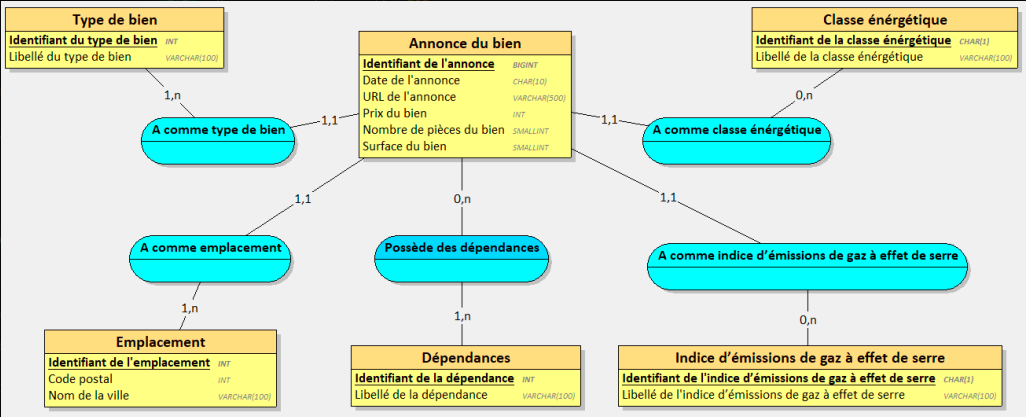

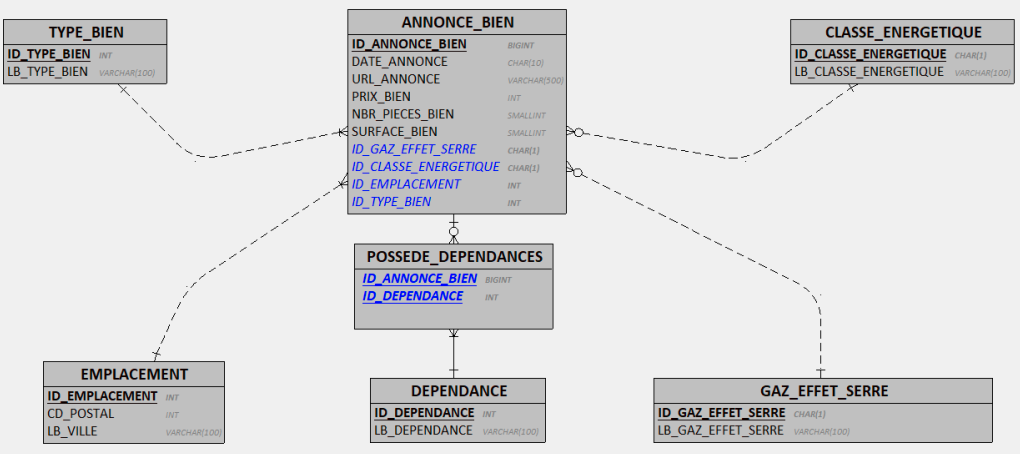

##    ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ************** ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ************** ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ************** ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ************** ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* ******* *******

<h1><center><font color='gray'>Traitement des données et conception de la BDD</font></center></h1>

In [48]:
## on copie la table afin de garder une version originale si on veut repartir de 0 sans avoir à tout relancer
dffinal=df_final.copy()

###  Traitement du champ type de bien (appart, maison,..) & création de la table référentielle

* Pour ce champ là nous allons remplacer remédier aux valeurs mal scrapper avec une formattage spécifique (cf-fonction creection_type_de_bien).  
Nous avons remarquer ces valeurs en faisant: df.typebien.value_counts() --> cette fonction a renvoyé les valeurs du champ en distinct & leur comptage. Par conséquent on s'est apperçus des valeurs anormales.  


* Nous allons créer aussi la table référentielle type de bien qui prend les valeurs du champ type de bien en distinct puis on leur associe l'index comme identifiant. Par la suite on remplace le champ type de bien dans la table des données scrapper par l'identifiant.

In [5]:
                ## **************************** Type de bien ************************************* ## 

def correction_type_de_bien(x):
    if x=="Enchère : \t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tVilla":
        return x.split("\t")[-1]
    elif x=="Plateau":
        return "local_commercial"
    else:
        return x

dffinal["lb_type_bien"]=dffinal["lb_type_bien"].apply(lambda x:correction_type_de_bien(x))

dffinal.to_csv('tmp_data/preprocessed_final_table.csv', index=False, encoding='utf-8')

In [49]:

### going to create a tab ref for type de bien 
df_typebien=pd.DataFrame(dffinal["lb_type_bien"]).drop_duplicates().reset_index(drop=True)
df_typebien=df_typebien.assign(id_type_bien=df_typebien.index)

df_typebien=df_typebien[["id_type_bien","lb_type_bien"]] ## une des sorties

## on convertit le dataframe ref des types de biens en dict & on permute key & values
dict_typebien={v: k for k, v in df_typebien.to_dict()["lb_type_bien"].items()}

dffinal["lb_type_bien"]=dffinal["lb_type_bien"].apply(lambda x:int(dict_typebien[x]))

dffinal.head(5)

,id,url,lb_type_bien,ville,price,pieces,surface,date_annonce,dependance,annexe,classe_energie,gaz_effet_serre
0,1260694776,https://www.paruvendu.fr/immobilier/vente/mais...,0,La Ferté-Gaucher (77320),97500,3,101,03/09/2022,NC,NC,E,B
1,1263297361,https://www.paruvendu.fr/immobilier/vente/appa...,1,Versailles (78000),499000,3,74,03/09/2022,Balcon,Parking,C,D
2,1263773523,https://www.paruvendu.fr/immobilier/vente/dupl...,2,Sevran (93270),226000,NC,78,03/09/2022,NC,NC,C,C
3,1263773560,https://www.paruvendu.fr/immobilier/prestige/m...,0,Chaville (92370),927000,7,118,03/09/2022,NC,Parking,NC,NC
4,1263773532,https://www.paruvendu.fr/immobilier/vente/appa...,1,Vélizy-Villacoublay (78140),278100,3,61,03/09/2022,Balcon,Cave,NC,NC


In [50]:
## VUE DE LA TABLE df_typebien
df_typebien

,id_type_bien,lb_type_bien
0,0,Maison
1,1,Appartement
2,2,Duplex/triplex
3,3,Villa
4,4,Chalet
5,5,Loft
6,6,Ferme
7,7,Propriété/château
8,8,Hôtel Particulier
9,9,Moulin


###  Traitement du champ ville & création de la table emplacement

* Pour ce champ là nous allons distinguer le code postal du nom de la ville/communne, ainsi construire les codes postaux de Paris selon l'arrondissement. Encore une fois on s'est apperçus du format & de ce qu'il faut traiter en appliquant un value_counts sur le champ en question.   


* Nous allons créer aussi la table référentielle emplacement qui comprend le code postal & le libellé de la ville en associant toujours l'index comme identifiant.

In [51]:
                ## **************************** Emplacement ************************************* ## 

## fonction qui va séparer la commune du code postal
## ainsi reconstituer le code postal des arr de Paris
def emplacement_generator(x):
    list_emp=x.split("(")

    ## si on est dans le cas général
    if len(list_emp)>1:
        libelle=list_emp[0]
        codepostal=re.sub('\D', '', list_emp[1])

    ## si on est dans le cas de Paris avec le arr à côté
    else:
        list_emp=list_emp[0].split(" ")
        libelle=list_emp[0]
        codepostal='750'+list_emp[1].zfill(2)

    return str(libelle),int(codepostal)

## on applique la fonction au champ ville & on en sort deux champs distincts
dffinal['lb_ville'],dffinal['cd_postal']=zip(*dffinal["ville"].map(emplacement_generator))


df_emplacement=pd.DataFrame(dffinal[['lb_ville','cd_postal']]).drop_duplicates().reset_index(drop=True)
df_emplacement=df_emplacement.assign(id_emplacement=df_emplacement.index)
df_emplacement=df_emplacement[["id_emplacement","cd_postal","lb_ville"]] ## une sortie


dffinal=dffinal.merge(df_emplacement,on=["cd_postal","lb_ville"],how='inner')
dffinal=dffinal.drop(["ville","lb_ville","cd_postal"],axis=1)
dffinal.head(5)

,id,url,lb_type_bien,price,pieces,surface,date_annonce,dependance,annexe,classe_energie,gaz_effet_serre,id_emplacement
0,1260694776,https://www.paruvendu.fr/immobilier/vente/mais...,0,97500,3,101,03/09/2022,NC,NC,E,B,0
1,1263749485,https://www.paruvendu.fr/immobilier/vente/mais...,0,419000,8,181,02/09/2022,NC,Box,D,D,0
2,1263748304,https://www.paruvendu.fr/immobilier/vente/appa...,1,59500,2,42,03/09/2022,NC,NC,NC,NC,0
3,1263711220,https://www.paruvendu.fr/immobilier/vente/mais...,0,122000,6,90,30/08/2022,NC,NC,NC,NC,0
4,1262885315,https://www.paruvendu.fr/immobilier/vente/mais...,0,148000,4,75,31/08/2022,NC,NC,C,A,0


In [52]:
## VUE DE LA TABLE EMPLACEMENT
df_emplacement

,id_emplacement,cd_postal,lb_ville
0,0,77320,La Ferté-Gaucher
1,1,78000,Versailles
2,2,93270,Sevran
3,3,92370,Chaville
4,4,78140,Vélizy-Villacoublay
...,...,...,...
969,969,91580,Villeconin
970,970,78750,Mareil-Marly
971,971,78270,Rolleboise
972,972,77390,Crisenoy


###  Traitement des champs : dépendances, annexes + création de la table lien annonce-dépendance

* Pour ces champs, nous allons les fusionner afin de créer une seule table référentielle des deux qui s"'"appellent dépendance. Cette dernière va avoir un id distinct pour chacune des dépendances et annexes. Cet id remplacera les deux champs dans la table

In [53]:
                    ## ************************** Dependance ********************************** ## 

### création de la table ref des dépendances
df_dependance=pd.DataFrame({"libelle_dependance":
                            list(set(dffinal["dependance"].values.tolist()+dffinal["annexe"].values.tolist()))},
                           columns=["libelle_dependance"])
df_dependance=df_dependance.assign(id_dependance=df_dependance.index)
df_dependance=df_dependance[["id_dependance","libelle_dependance"]] ## une des sorties


### création de la table lien entre les dépendances & les personnes
df1=dffinal[["id","dependance"]]
df1.columns=["id_entite_bien","libelle_dependance"]
df1=df1.merge(df_dependance,on=["libelle_dependance"],how='inner')

df2=dffinal[["id","annexe"]]
df2.columns=["id_entite_bien","libelle_dependance"]
df2=df2.merge(df_dependance,on=["libelle_dependance"],how='inner')

df_lien_bien_dependance=pd.concat([df1,df2]).drop_duplicates().reset_index(drop=True)
df_lien_bien_dependance=df_lien_bien_dependance[["id_entite_bien","id_dependance"]].drop_duplicates() ## une sortie


######
dffinal=dffinal.drop(["dependance","annexe"],axis=1).drop_duplicates()
dffinal.head(5)

,id,url,lb_type_bien,price,pieces,surface,date_annonce,classe_energie,gaz_effet_serre,id_emplacement
0,1260694776,https://www.paruvendu.fr/immobilier/vente/mais...,0,97500,3,101,03/09/2022,E,B,0
1,1263749485,https://www.paruvendu.fr/immobilier/vente/mais...,0,419000,8,181,02/09/2022,D,D,0
2,1263748304,https://www.paruvendu.fr/immobilier/vente/appa...,1,59500,2,42,03/09/2022,NC,NC,0
3,1263711220,https://www.paruvendu.fr/immobilier/vente/mais...,0,122000,6,90,30/08/2022,NC,NC,0
4,1262885315,https://www.paruvendu.fr/immobilier/vente/mais...,0,148000,4,75,31/08/2022,C,A,0


In [54]:
## VUE DE LA TABLE df_lien_bien_dependance
df_dependance

,id_dependance,libelle_dependance
0,0,Véranda
1,1,Cave
2,2,Parking
3,3,Grenier
4,4,Salle de jeux
5,5,Box
6,6,Terrasse
7,7,Double vitrage
8,8,NC
9,9,Balcon


In [55]:
## VUE DE LA TABLE df_lien_bien_dependance
df_lien_bien_dependance

,id_entite_bien,id_dependance
0,1260694776,8
1,1263749485,8
2,1263748304,8
3,1263711220,8
4,1262885315,8
...,...,...
21595,1263570788,7
21596,1263591843,7
21597,1257731870,7
21598,1262859358,7


###  Création des tables référentielles pour les indicateurs : énérgétiques & gaz effet de serre.

* Nous avons pu via le HTML trouvé la classe des indicateurs & non seulement la valeur. Ceci est un avantage car la valeur rentre dans le cadre d'un intervalle pour être interprétable ainsi dans le cas de l'utilisation des data par la suite pour un entrainement de modèles, il est plus logique d'avoir une classe pour ces champs qu'une valeur numérique.  

***/!\ ces tables gardent juste les références en valeurs de nos classes. Ils ne seront pas utilisés plus tard.***

In [56]:
## ************************************************************************** ## 
## Tables réf pour les infos énergétiques

df_class_energetique=pd.DataFrame({"id_classe_energetique":["A","B","C","D","E","F","G"],
"lb_classe_energetique" :["< 70","70 à 109","110 à 179","180 à 249","250 à 329","330 à 419",">= 420"]},
                                   columns=["id_classe_energetique","lb_classe_energetique"])

df_gaz_effet_serre=pd.DataFrame({"id_gaz_effet_serre":["A","B","C","D","E","F","G"],
"lb_gaz_effet_serre" :["< 6","6 à 10","11 à 29","30 à 49","50 à 69","70 à 99","> 100"]},
                                   columns=["id_gaz_effet_serre","lb_gaz_effet_serre"])

## VUE DE LA TABLE df_gaz_effet_serre 
df_gaz_effet_serre

,id_gaz_effet_serre,lb_gaz_effet_serre
0,A,< 6
1,B,6 à 10
2,C,11 à 29
3,D,30 à 49
4,E,50 à 69
5,F,70 à 99
6,G,> 100


In [57]:
## VUE DE LA TABLE df_class_energetique
df_class_energetique

,id_classe_energetique,lb_classe_energetique
0,A,< 70
1,B,70 à 109
2,C,110 à 179
3,D,180 à 249
4,E,250 à 329
5,F,330 à 419
6,G,>= 420


## Export des tables de la BDD

Dans cette partie nous allons juste revoir les noms des colonnes de la table finale puis exporter nos tables pour la partie construction de la BDD via python & insertion des data collectées.

In [58]:
## ************************************************************************** ## 
## Dernier formattage des noms des colonnes & leur types

    ## tables en sortie : 
    
## annonce_bien
dffinal.columns=["id_entite_bien","url","id_type_bien","prix","nb_pieces",
                 "surface","date_annonce",'id_classe_energie',"id_gaz_effet_serre","id_emplacement"]

dffinal.to_csv('data_webscrapping/annonce_bien.csv', index=False, encoding='utf-8')

## dependance 
df_dependance.to_csv('data_webscrapping/dependance.csv', index=False, encoding='utf-8')
 
## lien_dep_annonce
df_lien_bien_dependance.to_csv('data_webscrapping/lien_bien_dependance.csv', index=False, encoding='utf-8')

## gaz_effet_serre
df_gaz_effet_serre.to_csv('data_webscrapping/gaz_effet_serre.csv', index=False, encoding='utf-8')

## classe_energetique
df_class_energetique.to_csv('data_webscrapping/class_energetique.csv', index=False, encoding='utf-8')

## emplacement
df_emplacement.to_csv('data_webscrapping/emplacement.csv', index=False, encoding='utf-8')

## type bien
df_typebien.to_csv('data_webscrapping/type_bien.csv', index=False, encoding='utf-8')

# Partie organisation


## nettoyage :

 ### type de bien 
    # 1 - Enchère : \t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tVilla  --> Villa
    # 2 - Plateau --> local_commercial
    
 ### emplacement - Ville
    # - 1 récupérer code postal dans les ()
    # - 2 pour ceux sans () récupérer le chiffre & faire 750 + chiffre ( si sur un seul car ajouter un 0 lpad 2 car)
    


''' 
BDD :
    - annonce_bien : id {key}, url, prix, id_type_bien, code_postal, pieces, surface, classe_energie, gaz_effet_serre
        ## description de l'annonce/du bien

    - emplacement : code_postal, libelle_ville
    - type_bien : id_type_bien, libelle_type_bien

   ----------------------------------------------------------------- 
    - lien_bien_dep : id_bien, id_dep  ## a, 1 | a,2 | car association n - n entre annonce_bien <-> dependance
    - dependance : id_dep, libelle_dependance  ## on fusionne les dépendances & annexes  ## 1, cave | 2 , parking
'''